In [3]:
import numpy
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import Levenshtein
from Levenshtein import hamming
from itertools import combinations
import matplotlib.pyplot as plt
import math
import random
from Bio import pairwise2
from Bio import Align
from Bio.SubsMat import MatrixInfo
import sklearn.cluster
import itertools
import time
# import skbio
from IPython.display import Audio, display

In [4]:
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))

In [5]:
allDone()

In [6]:
# motifs = (numpy.genfromtxt('Final_data/365_VertKin_noMotifSite_motifs_19.10.18.csv',dtype='U'))
# fams = (numpy.genfromtxt('Final_data/365_VertKin_noMotifSite_fams_19.10.18.csv',dtype='U'))
# motifxFamMatrix = numpy.genfromtxt('Final_data/365_VertKin_noMotifSite_motifxFamMatrix_19.10.18.csv',delimiter=',',dtype=int)
# famDistMatrix = numpy.genfromtxt('Final_data/365_VertKin_noMotifSite_famDistMatrix_19.10.18.csv',delimiter=',',dtype=float)

motifs = (numpy.genfromtxt('Final_data/Finalfams_VertKin_motifs_19.10.20.csv',dtype='U'))
fams = (numpy.genfromtxt('Final_data/Finalfams_VertKin_fams_19.10.20.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('Final_data/Finalfams_VertKin_motifxFamMatrix_19.10.20.csv',delimiter=',',dtype=int)

In [7]:
# for i, row in enumerate(famDistMatrix):
#     for j, val in enumerate(row):
#         if i==j:
#             famDistMatrix[i][j] = 0.0
# famDistMatrix

In [8]:
## IF WANT TO USE PAM DIST MATRIX INSTEAD OF PHYLO MATRIX:

pamFams = (numpy.genfromtxt('Final_data/fams_forPamDistMatrix_19.10.16.csv',dtype='U'))
pamMatrix = (numpy.genfromtxt('Final_data/famDistanceMatrix_pam_19.10.16.csv',delimiter=',',dtype=float))

for i,each in enumerate(pamFams):
    pamFams[i] = each.upper()

famDistMatrix = numpy.full((len(fams),len(fams)),-1.0)

for fam in fams:
    fIdx1_set = numpy.where(fams==fam)[0][0]
    fIdx1_get = numpy.where(pamFams==fam)[0][0]
    for fam2 in fams:
        fIdx2_set = numpy.where(fams==fam2)[0][0]
        fIdx2_get = numpy.where(pamFams==fam2)[0][0]
        famDistMatrix[fIdx1_set][fIdx2_set] = pamMatrix[fIdx1_get][fIdx2_get]

In [9]:
# IF WANT TO NORMALIZE:

maximum = numpy.max(famDistMatrix)
minimum = numpy.min(famDistMatrix)

famDistMatrix_scaled = numpy.array((famDistMatrix))
for i in range(len(fams)):
    for j in range(len(fams)):
# if using tree ...
        # famDistMatrix_scaled[i][j] = 1.0 - float(famDistMatrix[i][j]-minimum)/(maximum-minimum) 
# if using PAM ...
        famDistMatrix_scaled[i][j] = float(famDistMatrix[i][j]-minimum)/(maximum-minimum) 
    

famDistMatrix = famDistMatrix_scaled
famDistMatrix

array([[0.46856471, 0.65399708, 0.89279365, 0.90353218, 0.96197885,
        0.90655903, 0.79469659, 0.93511938],
       [0.65399708, 0.1835669 , 0.89469944, 0.90478894, 0.96699141,
        0.89918661, 0.74406856, 0.93883657],
       [0.89279365, 0.89469944, 0.59401978, 0.75495611, 0.90759372,
        0.81393036, 0.91596173, 0.90431987],
       [0.90353218, 0.90478894, 0.75495611, 0.55254221, 0.90814889,
        0.8025133 , 0.91895141, 0.90635547],
       [0.96197885, 0.96699141, 0.90759372, 0.90814889, 0.52446844,
        0.96344319, 1.        , 0.96035117],
       [0.90655903, 0.89918661, 0.81393036, 0.8025133 , 0.96344319,
        0.        , 0.9463205 , 0.91498464],
       [0.79469659, 0.74406856, 0.91596173, 0.91895141, 1.        ,
        0.9463205 , 0.44751168, 0.96754561],
       [0.93511938, 0.93883657, 0.90431987, 0.90635547, 0.96035117,
        0.91498464, 0.96754561, 0.58133647]])

In [10]:
len(motifs)
# motifxFamMatrix.shape

7535

In [11]:
# motifs = motifs[:2000]

In [12]:
def getDistMatrix(myMotifs,kind):
    tripDict = dict( zip(range(len(myMotifs)),myMotifs) )
    invTripDict = {v:k for k,v in tripDict.items()}
    
    aligner = Align.PairwiseAligner()
    if kind=='PAM':
        aligner.substitution_matrix = MatrixInfo.pam30
    if kind=='BLOS':
        aligner.substitution_matrix = MatrixInfo.blosum62
    aligner.mode = 'local'
    
    combos=[]
    for each in (combinations(myMotifs,2)):   
        blosScore = aligner.align(each[0].lower(),each[1].lower()).score
        combos.append([each[0],each[1],blosScore]) # invert blosum score 
    
    maximum = max([x[2] for x in combos])
    minimum = min([x[2] for x in combos])
    for i in range(len(combos)):
        combos[i][2] = 1.00 - float(combos[i][2]-minimum)/(maximum-minimum)   # invert and norm  ???     
    
    mat = numpy.zeros((len(myMotifs),len(myMotifs)),dtype=float)
    for pair in combos:
        mat[invTripDict[pair[0]],invTripDict[pair[1]]] = pair[2]
        mat[invTripDict[pair[1]],invTripDict[pair[0]]] = pair[2]

    return mat

In [13]:
motifDistMatrix = getDistMatrix(motifs,'BLOS')
allDone()

In [211]:
# from itertools import combinations
# motifFamAvgDists = numpy.zeros((len(motifs),len(motifs)))

# for pair in combinations(motifs,2):
#     motif1 = pair[0]
#     motif2 = pair[1]
    
#     mIdx1 = numpy.where(motifs==motif1)[0][0]
#     mIdx2 = numpy.where(motifs==motif2)[0][0]
    
#     mFamsIdc1 = numpy.where(motifxFamMatrix[mIdx1]==1)[0]
# #     print(len(mFamsIdc1))
#     mFamsIdc2 = numpy.where(motifxFamMatrix[mIdx2]==1)[0]
    
#     famDists = []
    
#     for i,pair2 in enumerate(itertools.product(mFamsIdc1, mFamsIdc2)):
#         if i==1:
#             break
# #         print(pair2, fams[pair2[0]], fams[pair2[1]])
# #         print(famDistMatrix[pair2[0],pair2[1]])
#         famDists.append(famDistMatrix[pair2[0],pair2[1]])
#     avgFamDist = sum(famDists)/len(famDists)
# #     if avgFamDist==0 and mFamsIdc1!=mFamsIdc2:
# #         print(fams[mFamsIdc1],fams[mFamsIdc2])
#     motifFamAvgDists[mIdx1][mIdx2] = avgFamDist
#     motifFamAvgDists[mIdx2][mIdx1] = avgFamDist

# allDone()
    

In [14]:
from itertools import combinations
kMotifAvgDists = numpy.zeros((len(fams),len(fams)))

for pair in combinations(fams,2):
    fam1 = pair[0]
    fam2 = pair[1]
    
    fIdx1 = numpy.where(fams==fam1)[0][0]
    fIdx2 = numpy.where(fams==fam2)[0][0]
    
    kMotifIdc1 = [x for x in numpy.where(motifxFamMatrix.T[fIdx1]==1)[0] if x < len(motifs)]
    kMotifIdc2 = [x for x in numpy.where(motifxFamMatrix.T[fIdx2]==1)[0] if x < len(motifs)]
        
    motifDists = []
    
    if len(kMotifIdc1)==0 or len(kMotifIdc2)==0:
        continue
    
    for i,pair2 in enumerate(itertools.product(kMotifIdc1, kMotifIdc2)):
#         if i==1:
#             break
        motifDists.append(motifDistMatrix[pair2[0],pair2[1]])
#     avgMotifDist = sum(motifDists)/len(motifDists)
    avgMotifDist = numpy.mean(numpy.array((motifDists)))
    kMotifAvgDists[fIdx1][fIdx2] = avgMotifDist
    kMotifAvgDists[fIdx2][fIdx1] = avgMotifDist
    
#     break

allDone()

In [15]:
#### m-m distance against kinaseList-kinaseList distance

# mDist = numpy.triu(distMatrix)
# mDist = mDist.flatten()
# # poo = list(poo)

# kDist = numpy.triu(motifFamAvgDists)
# kDist = kDist.flatten()
# # poo2 = list(poo2)

# goodIdx = numpy.where(kDist!=1.0)[0]
# mDist = mDist[goodIdx]
# kDist = kDist[goodIdx]

# goodIdx = numpy.where(kDist!=0.0)[0]
# mDist = mDist[goodIdx]
# kDist = kDist[goodIdx]

# mDist = list(mDist)
# kDist = list(kDist)



#### K-K distance against motifList-motifList distance

kDist = numpy.triu(famDistMatrix)
kDist = kDist.flatten()
# print(kDist)

mDist = numpy.triu(kMotifAvgDists)
# print(numpy.where(mDist==0.0))
# print(mDist)
mDist = mDist.flatten()

goodIdx = numpy.where(kDist!=0.0)[0] # get rid of bottom triangle of famDistMatrix
kDist = kDist[goodIdx]
mDist = mDist[goodIdx]


goodIdx = numpy.where(mDist!=0.0)[0] # get rid of bottom triangle of motifDistMatrix
kDist = kDist[goodIdx]
mDist = mDist[goodIdx]

kDist = list(kDist)
mDist = list(mDist)

In [16]:
numpy.triu(famDistMatrix)

array([[0.46856471, 0.65399708, 0.89279365, 0.90353218, 0.96197885,
        0.90655903, 0.79469659, 0.93511938],
       [0.        , 0.1835669 , 0.89469944, 0.90478894, 0.96699141,
        0.89918661, 0.74406856, 0.93883657],
       [0.        , 0.        , 0.59401978, 0.75495611, 0.90759372,
        0.81393036, 0.91596173, 0.90431987],
       [0.        , 0.        , 0.        , 0.55254221, 0.90814889,
        0.8025133 , 0.91895141, 0.90635547],
       [0.        , 0.        , 0.        , 0.        , 0.52446844,
        0.96344319, 1.        , 0.96035117],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.9463205 , 0.91498464],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.44751168, 0.96754561],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.58133647]])

In [17]:
fams

array(['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK'],
      dtype='<U4')

In [18]:
famDistMatrix[-2][-2]

0.4475116837826057

In [19]:
toPlot = numpy.tril(famDistMatrix)
# toPlot[numpy.where(toPlot==0.00)] = 1.00

for i in range(len(toPlot)):
    for j in range(len(toPlot)):
        if i==j:
            toPlot[i][j]=0.0

toPlot

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.65399708, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.89279365, 0.89469944, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.90353218, 0.90478894, 0.75495611, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.96197885, 0.96699141, 0.90759372, 0.90814889, 0.        ,
        0.        , 0.        , 0.        ],
       [0.90655903, 0.89918661, 0.81393036, 0.8025133 , 0.96344319,
        0.        , 0.        , 0.        ],
       [0.79469659, 0.74406856, 0.91596173, 0.91895141, 1.        ,
        0.9463205 , 0.        , 0.        ],
       [0.93511938, 0.93883657, 0.90431987, 0.90635547, 0.96035117,
        0.91498464, 0.96754561, 0.        ]])

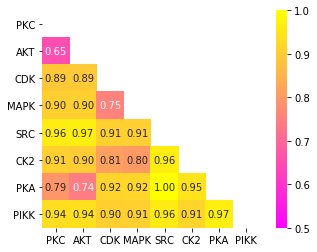

In [22]:
import seaborn as sb
# heat_map = sb.heatmap(toPlot, annot=True, cmap="plasma")
heat_map = sb.heatmap(toPlot, annot=True, cmap="spring", fmt='1.2f',
                      square=True, mask= toPlot == 0, yticklabels=fams, xticklabels=fams, vmin=0.5 )
# plt.savefig("results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/kinaseDistCorrelations")
plt.show()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # plt.style.use('default')
# plt.imshow(toPlot, cmap='viridis_r', interpolation='nearest')
# plt.set_xticks(np.arange(toPlot.shape[1]) + 0.5, minor=False)
# plt.set_yticks(np.arange(toPlot.shape[0]) + 0.5, minor=False)
# # ax.set_xticklabels(fams)
# # ax.set_yticklabels(fams)
# # plt.show()



# fig, ax = plt.subplots()
# fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

# heatmap = ax.pcolor(toPlot)
# cbar = plt.colorbar(heatmap)

# # Set ticks in center of cells
# ax.set_xticks(np.arange(toPlot.shape[1]) + 0.5, minor=False)
# ax.set_yticks(np.arange(toPlot.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
# ax.set_xticklabels(fams,rotation=90)
# ax.set_yticklabels(fams)


In [23]:
import pandas as pd
import os

f = "results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/"
# os.mkdir(f)

df = pd.DataFrame(kDist,dtype=float)
# df.to_csv("results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/kDist",header=None,index=None)

df = pd.DataFrame(mDist,dtype=float)
# df.to_csv("results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/mDist",header=None,index=None)

In [45]:
kDist = np.genfromtxt("results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/kDist",dtype=float)
mDist = np.genfromtxt("results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/mDist",dtype=float)


In [24]:
len(kDist)

28

In [31]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [32]:
from scipy.stats import linregress
sl,inte,rv,pv,std = linregress(kDist, mDist)

In [46]:
mDist

array([0.99993299, 0.99997848, 0.99997543, 0.99999748, 0.99998087,
       0.99979427, 0.99999033, 0.99998568, 0.99997865, 0.99999711,
       0.99999042, 0.99988613, 0.99998874, 0.99987053, 0.99999647,
       0.99998031, 0.99998194, 0.99996141, 0.99999557, 0.99998532,
       0.9999707 , 0.99995857, 0.99999291, 0.9999965 , 0.99999766,
       0.99997753, 0.99998645, 0.9999875 ])

In [33]:
rv**2

0.00017037702492378928

In [34]:
rsq = 0.5559583457451414**2
rsq

0.30908968220367417

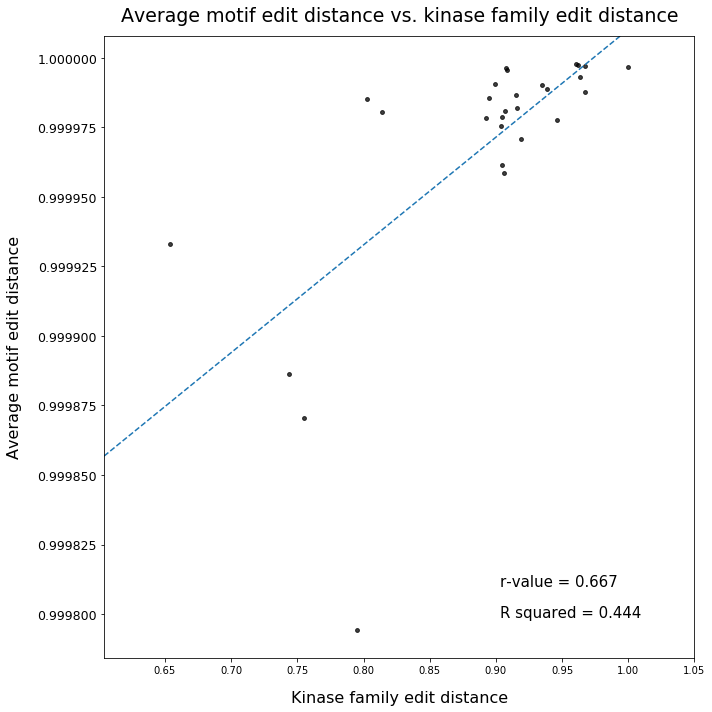

In [68]:
import numpy as np
import matplotlib.ticker as mtick

slope=sl
intercept=inte

p = 15
plt.figure(figsize=(10,10))
plt.xlabel('Kinase family edit distance', fontsize=16, labelpad=p)
plt.ylabel('Average motif edit distance', fontsize=16, labelpad=p)
plt.title('Average motif edit distance vs. kinase family edit distance', fontsize=19, pad=p)
plt.ylim(numpy.min(mDist)-0.00001, numpy.max(mDist)+0.00001)
plt.xlim(numpy.min(kDist)-0.05, numpy.max(kDist)+0.05)
# plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
plt.yticks(fontsize=12.5)

plt.annotate('r-value = %5.3f' % rv, xy=(.67, .115), xycoords='axes fraction',fontsize=15)
plt.annotate('R squared = %5.3f' % rv**2, xy=(.67, .065), xycoords='axes fraction',fontsize=15)

abline(slope, intercept)
plt.scatter(kDist, mDist, s=15, alpha=0.75,c='black') 

plt.tight_layout()
plt.savefig("results_REAL/absolutelyFINAL/correlation_fig5")
plt.show()


In [52]:
# import numpy as np

# slope=2.255141589703321
# intercept=-0.7461476752716045

# slope=0.13705998932170682
# intercept=0.6029266008164713


# p = 15
# plt.figure(figsize=(10,10))
# plt.xlabel('Kinase family edit distance', fontsize=16, labelpad=p)
# plt.ylabel('Average motif edit distance', fontsize=16, labelpad=p)
# plt.title('Average motif edit distance vs. kinase family edit distance', fontsize=19, pad=p)
# plt.ylim(numpy.min(mDist)-0.0005, numpy.max(mDist)+0.0005)
# plt.xlim(numpy.min(kDist)-0.05, numpy.max(kDist)+0.05)
# plt.xticks(fontsize=12.5)
# plt.yticks(fontsize=12.5)
# plt.annotate('r-value = 0.556', xy=(.67, .115), xycoords='axes fraction',fontsize=15)
# plt.annotate('R squared = 0.309', xy=(.67, .065), xycoords='axes fraction',fontsize=15)

# abline(slope, intercept)
# plt.scatter(kDist, mDist, s=15, alpha=0.75,c='black') 

# plt.savefig(f + "correlation_fig_TEST")
# plt.show()


In [67]:
f

'results_REAL/results_19.10.20_multiFams/CNNCNN_Finalfams_VertKin_Siam/correlation_coords/'

In [60]:
# plt.hist(kDist,bins=100)
# plt.hist(mDist,bins=30)

In [66]:
from scipy.stats.stats import pearsonr   
print (pearsonr(mDist,kDist))
print (numpy.corrcoef(mDist, kDist))

(0.5559583457451412, 7.340677909534624e-05)
